In [1]:
import numpy as np
import pandas as pd
import scipy
import librosa, librosa.display
import matplotlib.pyplot as plt
import matplotlib.style as ms
#ms.use('seaborn-muted')
import IPython.display as Ipd
import os
import sklearn

In [435]:
def SphericalToCartesian(ele, azi, dist):
    phi = np.deg2rad(90-ele)
    theta = np.deg2rad(azi)
    
    x = dist * np.sin(phi) * np.cos(theta)
    #x=ρsinφcosθ 
    y = dist * np.sin(phi) * np.sin(theta)
    #y=ρsinφsinθ 
    z = dist * np.cos(phi)
    #z=ρcosφ
    return np.array([x, y, z])

def CartesianToSpherical(x, y, z):
    dist = np.sqrt(x*x + y*y + z*z)
    theta = np.arctan2(y,x)    
    phi = np.arccos(z/dist)
    ele = 90 - np.rad2deg(phi)
    azi = np.rad2deg(theta)
    return np.array([round(ele), round(azi), round(dist), theta])

def normalize(v):
    norm=np.linalg.norm(v)
    if norm==0:
        norm=np.finfo(v.dtype).eps
    return v/norm


#Get all metadata

filenames_meta = os.listdir('data/dcase_data/testing/metadata_eval') #Development

full_metadata = pd.DataFrame()
#all_metadata
max_it = 400
c = 0
for i in range(len(filenames_meta)):
    metadata = pd.read_csv('data/dcase_data/testing/metadata_eval/' + filenames_meta[i])  #Development
    coord = np.zeros((len(metadata),3))
    sphe = np.zeros((len(metadata),4))
    for index, row in metadata.iterrows():
        coord[index, :] = SphericalToCartesian(row['ele'], row['azi'], row['dist'])
        sphe[index, :] = CartesianToSpherical(coord[index, 0], coord[index, 1], coord[index, 2])
    metadata['x'] = coord[:,0]
    metadata['y'] = coord[:,1]
    metadata['z'] = coord[:,2]
    
    metadata['ele_r'] = sphe[:,0]
    metadata['azi_r'] = sphe[:,1]
    metadata['dist_r'] = sphe[:,2]
    metadata['theta'] = sphe[:,3]
    
    full_metadata = full_metadata.append(metadata, ignore_index=True, sort=False)
    c +=1
    if c == max_it:
        break
print(len(full_metadata))
print(len(full_metadata.loc[full_metadata['sound_event_recording'] == 'phone']))

3974
382


In [ ]:
full_metadata

In [ ]:
def showMel(S):
    fig, ax = plt.subplots()
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB, x_axis='time',
                             y_axis='mel', sr=sr,
                             fmax=8000, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel-frequency spectrogram')

In [ ]:
#defining function to interpolate 2-D dimensional arrays
def lin_interp_2d(data, out_size):
    
    x_in_size = data.shape[1]
    y_in_size = data.shape[0]
    x_in = np.arange(0,x_in_size)
    y_in = np.arange(0,y_in_size)
    interpolator = scipy.interpolate.interp2d(x_in, y_in, data, kind='linear')
    x_out = np.arange(0,x_in_size-1,((x_in_size-1)/out_size[1]))
    y_out = np.arange(0,y_in_size-1,((y_in_size-1)/out_size[0]))
    output = interpolator(x_out, y_out)
    output = output[0:out_size[0],0:out_size[1]]
    
    return output

def getSpectrum(s):
    y = s[0:2048] * scipy.signal.blackmanharris(2048)
    X_amp = np.abs(np.fft.rfft(y))
    X_db = 20 * np.log10(X_amp)
    #freqs = np.fft.rfftfreq(2048, 1/sr)#this is not used
    return X_db

# def get_lag_feature(signal):
#     output = []
#     for i in range(signal.shape[0] - 1):
#         for j in range(i + 1, signal.shape[0]):
#             #print(i,"*" ,j)
#             cross = scipy.signal.correlate(signal[i], signal[j], mode ='full')
#             output.append(np.argmax(cross)-len(cross)/2)
#     return output

# def extract_features_target(signal, ele, azi, dist):
# #     output = librosa.feature.melspectrogram(signal[0], n_mels=15)
# #     output = output.flatten()
#     #output_time = get_lag_feature(signal)
    
    
#     melSig = np.zeros((4, melFreSize*melTimeSamples))
#     for i in range(signal.shape[0]):
#         melSpec = librosa.feature.melspectrogram(signal[i], n_mels=melFreSize)
#         print(signal[i].shape, ", ", signal[i,:].shape)
        
        
#         melSpec = lin_interp_2d(melSpec, (melFreSize, melTimeSamples))
#         showMel(melSpec)
#         melSig[i,:] = melSpec.flatten()
#     #output_freq = get_lag_feature(melSig)
#     output_mel = melSig.flatten()
    
    
#     #for i in range(signal.shape[0]):
#     #    output.extend([np.mean(signal[i]), np.var(signal[i])])
#     #output_time.extend(output_freq)
#     return output_mel, np.array([ele, azi, dist])

In [22]:
sr = 22050
def lin_interp_2d(data, out_size):
    
    x_in_size = data.shape[1]
    y_in_size = data.shape[0]
    x_in = np.arange(0,x_in_size)
    y_in = np.arange(0,y_in_size)
    interpolator = scipy.interpolate.interp2d(x_in, y_in, data, kind='linear')
    x_out = np.arange(0,x_in_size-1,((x_in_size-1)/out_size[1]))
    y_out = np.arange(0,y_in_size-1,((y_in_size-1)/out_size[0]))
    output = interpolator(x_out, y_out)
    output = output[0:out_size[0],0:out_size[1]]
    
    return output

def extract_features_target(signal, location):
    stft_amp = np.zeros((128,0))
    stft_phase = np.zeros((128,0))
    for i in range(4):
        stft = librosa.stft(signal[i], n_fft=1024, hop_length=512)
        stft_amp = np.append(stft_amp, lin_interp_2d(librosa.amplitude_to_db(np.abs(stft)), (128,64)), axis=1)
        stft_phase = np.append(stft_phase, lin_interp_2d(np.angle(stft), (128,64)), axis = 1)

        #print(stft_amp.shape)
        #print(np.std(stft_amp[0]))


    stft_amp = sklearn.preprocessing.scale(stft_amp, axis = 1)
    stft_phase = sklearn.preprocessing.scale(stft_phase, axis = 1)

    feature = np.append(stft_amp.flatten(), stft_phase.flatten())
    return feature, np.array(location)


In [39]:
# sr = 22050
# melFreSize = 128
# melTimeSamples = 1024

# # def get_combine_feature(signal):
# #     output = []
# #     for i in range(signal.shape[0] - 1):
# #         for j in range(i + 1, signal.shape[0]):
# #             #print(i,"*" ,j)
# #             #Lag calculation
# #             cross = scipy.signal.correlate(signal[i], signal[j], mode ='full')
# #             output.append(np.argmax(cross)-len(cross)/2)
# #             #RMS Diference
# #             rmsDiff = np.mean(librosa.feature.rms(signal[i])) - np.mean(librosa.feature.rms(signal[j]))
# #             output.append(rmsDiff)
# #     return output

# def get_combine_feature(signal):
# #     output = []
# #     for i in range(signal.shape[0] - 1):
# #         for j in range(i + 1, signal.shape[0]):
# #             cross = scipy.signal.correlate(signal[i], signal[j], mode ='full')
# #             output.append(np.argmax(cross)-len(cross)/2)

# #     lag = sklearn.preprocessing.normalize(np.array(output).reshape(1,-1))
    
#     output = []
#     for i in range(signal.shape[0] - 1):
#           for j in range(i + 1, signal.shape[0]):
#             rmsDiff = np.mean(librosa.feature.rms(signal[i])) - np.mean(librosa.feature.rms(signal[j]))
#             output.append(rmsDiff)

#     rms = sklearn.preprocessing.normalize(np.array(output).reshape(1,-1))
    
#     output = []        
#     for i in range(signal.shape[0] - 1):
#           for j in range(i + 1, signal.shape[0]):
#             #RMS from spectrum Diference
#             rmsDiff = np.mean(librosa.feature.rms(getSpectrum(signal[i]))) - np.mean(librosa.feature.rms(getSpectrum(signal[j])))
#             output.append(rmsDiff)

#     rms_spec = sklearn.preprocessing.normalize(np.array(output).reshape(1,-1))

#     #output = lag.flatten().tolist()
#     #output.extend(rms.flatten().tolist())
#     output = rms.flatten().tolist()
#     output.extend(rms_spec.flatten().tolist())
#     return output

# def extract_features_target(signal, location):
# #     output_time = get_combine_feature(signal)   
# #         #for i in range(signal.shape[0]):
# #     #    output.extend([np.mean(signal[i]), np.var(signal[i])])
# #     return output_time, np.array(location)
# #     output = librosa.feature.melspectrogram(signal[0], n_mels=15)
# #     output = output.flatten()
#     #output_time = get_lag_feature(signal)
    
    
#     melSig = np.zeros((4, melFreSize*melTimeSamples))
#     for i in range(signal.shape[0]):
#         melSpec = librosa.feature.melspectrogram(signal[i], n_mels=melFreSize)
#         #print(signal[i].shape, ", ", signal[i,:].shape)
        
        
#         melSpec = lin_interp_2d(melSpec, (melFreSize, melTimeSamples))
#         #showMel(melSpec)
#         melSig[i,:] = melSpec.flatten()
#     #output_freq = get_lag_feature(melSig)
#     output_mel = melSig.flatten()
    
    
#     #for i in range(signal.shape[0]):
#     #    output.extend([np.mean(signal[i]), np.var(signal[i])])
#     #output_time.extend(output_freq)
#     return output_mel, np.array(location)

#creating an array of zeros of the proper size where we will store computed features and lables

filenames_meta = os.listdir('data/dcase_data/metadata_dev') #Development
features = np.zeros((len(full_metadata),65536)) #we compute the melspectrogram which once flattened will produce 22144 values
target = np.zeros((len(full_metadata),3)) #we store the 2 target values

example = 0
for i in range(max_it):
    
    #Metadata
    metadata = pd.read_csv('data/dcase_data/metadata_dev/' + filenames_meta[i])  #Development
    filename = os.path.splitext(filenames_meta[i])[0]
    
    print("processing '" + filename + "' " + str(i + 1) + "/" + str(max_it))
    
    #Audio track
    signal, dummy = librosa.load('data/dcase_data/foa_dev/' + filename + '.wav', sr, mono=False)    
    
    for s in range(len(metadata)):
        if(metadata['sound_event_recording'][s] == 'phone' ):
            #print('processing',filenames[i])
            start_time = int(metadata['start_time'][s] * sr)
            end_time = int(metadata['end_time'][s] * sr)
            #print(str(end_time - start_time))
            subsignal = signal[:, start_time:end_time]
            #features[example,:], target[example,:] = extract_features_target(subsignal, metadata['x'][s],  metadata['y'][s], metadata['z'][s])
            features[example,:], target[example,:] = extract_features_target(subsignal, normalize(SphericalToCartesian(metadata['ele'][s],  metadata['azi'][s], metadata['dist'][s])))
            
            #Ipd.display(Ipd.Audio(subsignal, rate=sr))
            example += 1
print(features.shape)            
features = np.delete(features, np.arange(example,features.shape[0], 1, dtype=int), axis=0)
target = np.delete(target, np.arange(example,target.shape[0], 1, dtype=int), axis=0)
print('Done!')
print(features.shape)
print(example)


processing 'split1_ir0_ov1_1' 1/400
processing 'split1_ir0_ov1_10' 2/400
processing 'split1_ir0_ov1_2' 3/400
processing 'split1_ir0_ov1_3' 4/400
processing 'split1_ir0_ov1_4' 5/400
processing 'split1_ir0_ov1_5' 6/400
processing 'split1_ir0_ov1_6' 7/400
processing 'split1_ir0_ov1_7' 8/400
processing 'split1_ir0_ov1_8' 9/400
processing 'split1_ir0_ov1_9' 10/400
processing 'split1_ir0_ov2_11' 11/400
processing 'split1_ir0_ov2_12' 12/400
processing 'split1_ir0_ov2_13' 13/400
processing 'split1_ir0_ov2_14' 14/400
processing 'split1_ir0_ov2_15' 15/400
processing 'split1_ir0_ov2_16' 16/400
processing 'split1_ir0_ov2_17' 17/400
processing 'split1_ir0_ov2_18' 18/400
processing 'split1_ir0_ov2_19' 19/400
processing 'split1_ir0_ov2_20' 20/400
processing 'split1_ir1_ov1_21' 21/400
processing 'split1_ir1_ov1_22' 22/400
processing 'split1_ir1_ov1_23' 23/400
processing 'split1_ir1_ov1_24' 24/400
processing 'split1_ir1_ov1_25' 25/400
processing 'split1_ir1_ov1_26' 26/400
processing 'split1_ir1_ov1_27'

processing 'split3_ir0_ov2_15' 215/400
processing 'split3_ir0_ov2_16' 216/400
processing 'split3_ir0_ov2_17' 217/400
processing 'split3_ir0_ov2_18' 218/400
processing 'split3_ir0_ov2_19' 219/400
processing 'split3_ir0_ov2_20' 220/400
processing 'split3_ir1_ov1_21' 221/400
processing 'split3_ir1_ov1_22' 222/400
processing 'split3_ir1_ov1_23' 223/400
processing 'split3_ir1_ov1_24' 224/400
processing 'split3_ir1_ov1_25' 225/400
processing 'split3_ir1_ov1_26' 226/400
processing 'split3_ir1_ov1_27' 227/400
processing 'split3_ir1_ov1_28' 228/400
processing 'split3_ir1_ov1_29' 229/400
processing 'split3_ir1_ov1_30' 230/400
processing 'split3_ir1_ov2_31' 231/400
processing 'split3_ir1_ov2_32' 232/400
processing 'split3_ir1_ov2_33' 233/400
processing 'split3_ir1_ov2_34' 234/400
processing 'split3_ir1_ov2_35' 235/400
processing 'split3_ir1_ov2_36' 236/400
processing 'split3_ir1_ov2_37' 237/400
processing 'split3_ir1_ov2_38' 238/400
processing 'split3_ir1_ov2_39' 239/400
processing 'split3_ir1_ov

In [299]:
def lin_interp_2d(data, out_size):
    
    x_in_size = data.shape[1]
    y_in_size = data.shape[0]
    x_in = np.arange(0,x_in_size)
    y_in = np.arange(0,y_in_size)
    interpolator = scipy.interpolate.interp2d(x_in, y_in, data, kind='linear')
    x_out = np.arange(0,x_in_size-1,((x_in_size-1)/out_size[1]))
    y_out = np.arange(0,y_in_size-1,((y_in_size-1)/out_size[0]))
    output = interpolator(x_out, y_out)
    output = output[0:out_size[0],0:out_size[1]]
    
    return output

# def extract_features_target(signal, location):
#     stft_amp = np.zeros((128,0))
#     stft_phase = np.zeros((128,0))
#     for i in range(4):
#         stft = librosa.stft(signal[i], n_fft=1024, hop_length=512)
#         #stft_amp = np.append(stft_amp, lin_interp_2d(librosa.amplitude_to_db(np.abs(stft)), (128,64)), axis=1)
#         stft_amp = np.append(stft_amp, lin_interp_2d(np.abs(stft), (128,64)), axis=1)
#         stft_phase = np.append(stft_phase, lin_interp_2d(np.angle(stft), (128,64)), axis = 1)

#         #print(stft_amp.shape)
#         #print(np.std(stft_amp[0]))


#     stft_amp = sklearn.preprocessing.scale(stft_amp, axis = 1)
#     stft_phase = sklearn.preprocessing.scale(stft_phase, axis = 1)

#     feature = np.append(stft_amp.flatten(), stft_phase.flatten())
#     return feature, np.array(location)



def extract_features_target(signal, location):
    stft_w = librosa.stft(signal[0], n_fft=1024, hop_length=512)
    feature = []
    for ch in range(1,4):
        stft = librosa.stft(signal[ch], n_fft=1024, hop_length=512)
        i = np.abs(np.matmul(np.conjugate(stft_w), np.transpose(stft)))
        i_norm = sklearn.preprocessing.normalize(lin_interp_2d(i, (64, 64)), axis = 1)
        feature = np.append(feature, i_norm.flatten())
        
    return feature, np.array(location)

sr = 22050
filenames_meta = os.listdir('data/dcase_data/metadata_dev') #Development 65536
features = np.zeros((len(full_metadata),12288)) #we compute the melspectrogram which once flattened will produce 22144 values
target = np.zeros((len(full_metadata),3)) #we store the 2 target values
example = 0
for i in range(max_it):
    
    #Metadata
    metadata = pd.read_csv('data/dcase_data/metadata_dev/' + filenames_meta[i])  #Development
    filename = os.path.splitext(filenames_meta[i])[0]
    
    print("processing '" + filename + "' " + str(i + 1) + "/" + str(max_it))
    
    #Audio track
    signal, dummy = librosa.load('data/dcase_data/foa_dev/' + filename + '.wav', sr, mono=False)    
    
    for s in range(len(metadata)):
        #if(metadata['sound_event_recording'][s] == 'phone' ):
        #print('processing',filenames[i])
        start_time = int(metadata['start_time'][s] * sr)
        end_time = int(metadata['end_time'][s] * sr)
        #print(str(end_time - start_time))
        #subsignal = librosa.util.normalize(signal[:, start_time:end_time])
        subsignal = signal[:, start_time:end_time]
        #features[example,:], target[example,:] = extract_features_target(subsignal, metadata['x'][s],  metadata['y'][s], metadata['z'][s])
        features[example,:], target[example,:] = extract_features_target(subsignal, normalize(SphericalToCartesian(metadata['ele'][s],  metadata['azi'][s], metadata['dist'][s])))
            
        #Ipd.display(Ipd.Audio(subsignal, rate=sr))
        example += 1
print(features.shape)            
features = np.delete(features, np.arange(example,features.shape[0], 1, dtype=int), axis=0)
target = np.delete(target, np.arange(example,target.shape[0], 1, dtype=int), axis=0)
print('Done!')
print(features.shape)
print(example)

processing 'split1_ir0_ov1_1' 1/100
processing 'split1_ir0_ov1_10' 2/100
processing 'split1_ir0_ov1_2' 3/100
processing 'split1_ir0_ov1_3' 4/100
processing 'split1_ir0_ov1_4' 5/100
processing 'split1_ir0_ov1_5' 6/100
processing 'split1_ir0_ov1_6' 7/100
processing 'split1_ir0_ov1_7' 8/100
processing 'split1_ir0_ov1_8' 9/100
processing 'split1_ir0_ov1_9' 10/100
processing 'split1_ir0_ov2_11' 11/100
processing 'split1_ir0_ov2_12' 12/100
processing 'split1_ir0_ov2_13' 13/100
processing 'split1_ir0_ov2_14' 14/100
processing 'split1_ir0_ov2_15' 15/100
processing 'split1_ir0_ov2_16' 16/100
processing 'split1_ir0_ov2_17' 17/100
processing 'split1_ir0_ov2_18' 18/100
processing 'split1_ir0_ov2_19' 19/100
processing 'split1_ir0_ov2_20' 20/100
processing 'split1_ir1_ov1_21' 21/100
processing 'split1_ir1_ov1_22' 22/100
processing 'split1_ir1_ov1_23' 23/100
processing 'split1_ir1_ov1_24' 24/100
processing 'split1_ir1_ov1_25' 25/100
processing 'split1_ir1_ov1_26' 26/100
processing 'split1_ir1_ov1_27'

In [413]:

#defining function to interpolate 1-D dimensional arrays
def lin_interp_1d(data, out_size):
    
    in_size = data.shape[0]
    x_in = np.arange(0,in_size)
    interpolator = scipy.interpolate.interp1d(x_in, data)
    x_out = np.arange(0,in_size-1,((in_size-1)/out_size))
    output = interpolator(x_out)
    output = output[0:out_size]
    
    return output

def lin_interp_2d(data, out_size):
    
    x_in_size = data.shape[1]
    y_in_size = data.shape[0]
    x_in = np.arange(0,x_in_size)
    y_in = np.arange(0,y_in_size)
    interpolator = scipy.interpolate.interp2d(x_in, y_in, data, kind='linear')
    x_out = np.arange(0,x_in_size-1,((x_in_size-1)/out_size[1]))
    y_out = np.arange(0,y_in_size-1,((y_in_size-1)/out_size[0]))
    output = interpolator(x_out, y_out)
    output = output[0:out_size[0],0:out_size[1]]
    
    return output

# def extract_features_target(signal, location):
#     stft_amp = np.zeros((128,0))
#     stft_phase = np.zeros((128,0))
#     for i in range(4):
#         stft = librosa.stft(signal[i], n_fft=1024, hop_length=512)
#         #stft_amp = np.append(stft_amp, lin_interp_2d(librosa.amplitude_to_db(np.abs(stft)), (128,64)), axis=1)
#         stft_amp = np.append(stft_amp, lin_interp_2d(np.abs(stft), (128,64)), axis=1)
#         stft_phase = np.append(stft_phase, lin_interp_2d(np.angle(stft), (128,64)), axis = 1)

#         #print(stft_amp.shape)
#         #print(np.std(stft_amp[0]))


#     stft_amp = sklearn.preprocessing.scale(stft_amp, axis = 1)
#     stft_phase = sklearn.preprocessing.scale(stft_phase, axis = 1)

#     feature = np.append(stft_amp.flatten(), stft_phase.flatten())
#     return feature, np.array(location)



def extract_features_target(signal, location):
    stft_w = librosa.stft(signal[0], n_fft=1024, hop_length=512)
    feature = []
#     for ch in range(1,4):
#         stft = librosa.stft(signal[ch], n_fft=1024, hop_length=512)
#         i = np.abs(np.matmul(np.conjugate(stft_w), np.transpose(stft)))
#         i_norm = sklearn.preprocessing.normalize(lin_interp_2d(i, (64, 64)), axis = 1)
#         feature = np.append(feature, i_norm.flatten())
    for ch in range(1,4):    
        cross = scipy.signal.csd(signal[0], signal[ch], fs = sr, nperseg=1024, noverlap=512)
        cross = lin_interp_1d(np.angle(cross[1]), 256)
        cross = librosa.util.normalize(cross)
        feature = np.append(feature, cross)
        
    return feature, np.array(location)

sr = 22050
filenames_meta = os.listdir('data/dcase_data/metadata_dev') #Development 65536 12288
features = np.zeros((len(full_metadata),768)) #we compute the melspectrogram which once flattened will produce 22144 values
target = np.zeros((len(full_metadata),3)) #we store the 2 target values
example = 0
for i in range(max_it):
    
    #Metadata
    metadata = pd.read_csv('data/dcase_data/metadata_dev/' + filenames_meta[i])  #Development
    filename = os.path.splitext(filenames_meta[i])[0]
    
    print("processing '" + filename + "' " + str(i + 1) + "/" + str(max_it))
    
    #Audio track
    signal, dummy = librosa.load('data/dcase_data/foa_dev/' + filename + '.wav', sr, mono=False)    
    
    for s in range(len(metadata)):
        #if(metadata['sound_event_recording'][s] == 'phone' ):
        #print('processing',filenames[i])
        start_time = int(metadata['start_time'][s] * sr)
        end_time = int(metadata['end_time'][s] * sr)
        #print(str(end_time - start_time))
        subsignal = librosa.util.normalize(signal[:, start_time:end_time])
        #features[example,:], target[example,:] = extract_features_target(subsignal, metadata['x'][s],  metadata['y'][s], metadata['z'][s])
        features[example,:], target[example,:] = extract_features_target(subsignal, normalize(SphericalToCartesian(metadata['ele'][s],  metadata['azi'][s], metadata['dist'][s])))

        #Ipd.display(Ipd.Audio(subsignal, rate=sr))
        example += 1
print(features.shape)            
features = np.delete(features, np.arange(example,features.shape[0], 1, dtype=int), axis=0)
target = np.delete(target, np.arange(example,target.shape[0], 1, dtype=int), axis=0)
print('Done!')
print(features.shape)
print(example)

processing 'split1_ir0_ov1_1' 1/400
processing 'split1_ir0_ov1_10' 2/400
processing 'split1_ir0_ov1_2' 3/400
processing 'split1_ir0_ov1_3' 4/400
processing 'split1_ir0_ov1_4' 5/400
processing 'split1_ir0_ov1_5' 6/400
processing 'split1_ir0_ov1_6' 7/400
processing 'split1_ir0_ov1_7' 8/400
processing 'split1_ir0_ov1_8' 9/400
processing 'split1_ir0_ov1_9' 10/400
processing 'split1_ir0_ov2_11' 11/400
processing 'split1_ir0_ov2_12' 12/400
processing 'split1_ir0_ov2_13' 13/400
processing 'split1_ir0_ov2_14' 14/400
processing 'split1_ir0_ov2_15' 15/400
processing 'split1_ir0_ov2_16' 16/400
processing 'split1_ir0_ov2_17' 17/400
processing 'split1_ir0_ov2_18' 18/400
processing 'split1_ir0_ov2_19' 19/400
processing 'split1_ir0_ov2_20' 20/400
processing 'split1_ir1_ov1_21' 21/400
processing 'split1_ir1_ov1_22' 22/400
processing 'split1_ir1_ov1_23' 23/400
processing 'split1_ir1_ov1_24' 24/400
processing 'split1_ir1_ov1_25' 25/400
processing 'split1_ir1_ov1_26' 26/400
processing 'split1_ir1_ov1_27'

processing 'split3_ir0_ov2_15' 215/400
processing 'split3_ir0_ov2_16' 216/400
processing 'split3_ir0_ov2_17' 217/400
processing 'split3_ir0_ov2_18' 218/400
processing 'split3_ir0_ov2_19' 219/400
processing 'split3_ir0_ov2_20' 220/400
processing 'split3_ir1_ov1_21' 221/400
processing 'split3_ir1_ov1_22' 222/400
processing 'split3_ir1_ov1_23' 223/400
processing 'split3_ir1_ov1_24' 224/400
processing 'split3_ir1_ov1_25' 225/400
processing 'split3_ir1_ov1_26' 226/400
processing 'split3_ir1_ov1_27' 227/400
processing 'split3_ir1_ov1_28' 228/400
processing 'split3_ir1_ov1_29' 229/400
processing 'split3_ir1_ov1_30' 230/400
processing 'split3_ir1_ov2_31' 231/400
processing 'split3_ir1_ov2_32' 232/400
processing 'split3_ir1_ov2_33' 233/400
processing 'split3_ir1_ov2_34' 234/400
processing 'split3_ir1_ov2_35' 235/400
processing 'split3_ir1_ov2_36' 236/400
processing 'split3_ir1_ov2_37' 237/400
processing 'split3_ir1_ov2_38' 238/400
processing 'split3_ir1_ov2_39' 239/400
processing 'split3_ir1_ov

In [37]:
print(target)

[[ 0.3213938  -0.88302222 -0.34202014]
 [-0.49240388 -0.85286853  0.17364818]
 [ 0.92541658  0.33682409  0.17364818]
 [-0.75440651  0.13302222 -0.64278761]
 [ 0.13302222  0.75440651  0.64278761]]


(15798, 768)


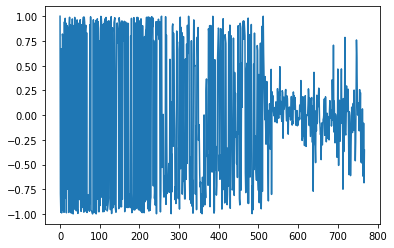

In [434]:
#print(features[100,:])
#for i in range(200):
#    plt.plot(features[i+20,:])
print(features.shape)
plt.plot(features[19])

In [ ]:
print(target[2,:])

In [417]:
from sklearn.model_selection import train_test_split

#splitting the dataset in training and testing parts
feat_train, feat_test, tar_train, tar_test = train_test_split(features, target, test_size=0.20, random_state=17)

In [418]:
print(feat_test.shape)
plt.plot(feat_train[0])

(3160, 768)


TypeError: plot() missing 1 required positional argument: 'ys'

(3160, 256)


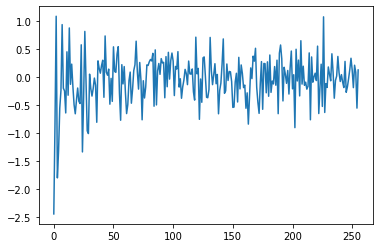

In [433]:
print(feat_test.shape)
plt.plot(feat_train[51])

In [197]:
for i in range(tar_train.shape[0]):
    for j in range(tar_train.shape[0]):
        if tar_train[i,0] == tar_train[j,0] and tar_train[i,1] == tar_train[j,1] and tar_train[i,2] == tar_train[j,2] and i != j:
            print(i , ",", j)

0 , 296
0 , 449
0 , 603
0 , 993
1 , 156
1 , 564
1 , 584
1 , 682
2 , 630
2 , 913
5 , 260
5 , 681
5 , 1082
6 , 273
6 , 425
6 , 752
6 , 1128
7 , 219
7 , 709
7 , 745
7 , 791
7 , 792
8 , 138
8 , 478
8 , 983
9 , 10
9 , 753
9 , 1049
10 , 9
10 , 753
10 , 1049
11 , 37
11 , 244
11 , 300
11 , 419
11 , 427
11 , 608
11 , 1070
12 , 87
12 , 363
12 , 516
12 , 811
12 , 955
13 , 110
13 , 257
13 , 377
13 , 588
13 , 738
14 , 277
14 , 426
14 , 483
15 , 160
15 , 256
15 , 499
15 , 951
16 , 29
16 , 870
16 , 1032
18 , 348
18 , 381
19 , 191
19 , 202
19 , 288
19 , 291
19 , 492
19 , 619
19 , 771
19 , 970
19 , 998
20 , 238
20 , 253
20 , 523
20 , 613
20 , 642
20 , 652
20 , 717
20 , 1048
21 , 382
21 , 395
21 , 424
21 , 465
21 , 532
21 , 723
21 , 1050
22 , 329
22 , 345
23 , 989
24 , 132
24 , 142
24 , 417
24 , 476
24 , 777
24 , 788
24 , 817
25 , 712
25 , 733
25 , 790
25 , 900
25 , 994
25 , 1116
26 , 699
27 , 81
27 , 680
27 , 1068
28 , 163
28 , 186
28 , 192
28 , 520
28 , 657
28 , 1134
29 , 16
29 , 870
29 , 1032
30 , 15

278 , 52
278 , 145
278 , 389
279 , 610
280 , 303
280 , 322
280 , 401
280 , 498
280 , 626
280 , 1102
280 , 1119
281 , 237
281 , 1054
282 , 270
282 , 387
282 , 530
282 , 761
282 , 823
282 , 832
283 , 328
283 , 739
283 , 756
283 , 991
284 , 40
284 , 154
284 , 189
284 , 337
284 , 440
284 , 496
284 , 536
284 , 1055
284 , 1063
285 , 567
285 , 690
285 , 1011
286 , 64
286 , 531
286 , 643
286 , 648
286 , 650
286 , 774
286 , 805
286 , 849
287 , 226
287 , 418
287 , 488
287 , 949
288 , 19
288 , 191
288 , 202
288 , 291
288 , 492
288 , 619
288 , 771
288 , 970
288 , 998
289 , 50
289 , 258
289 , 405
289 , 489
289 , 524
289 , 845
289 , 854
290 , 422
290 , 1132
291 , 19
291 , 191
291 , 202
291 , 288
291 , 492
291 , 619
291 , 771
291 , 970
291 , 998
292 , 127
292 , 131
292 , 159
292 , 182
292 , 235
292 , 371
292 , 867
292 , 922
292 , 1058
292 , 1097
293 , 390
293 , 587
293 , 807
293 , 835
293 , 957
293 , 1044
294 , 105
294 , 302
294 , 568
294 , 620
294 , 1037
294 , 1084
295 , 53
295 , 727
296 , 0
296 , 4

527 , 558
528 , 653
528 , 1033
529 , 103
529 , 651
529 , 1019
530 , 270
530 , 282
530 , 387
530 , 761
530 , 823
530 , 832
531 , 64
531 , 286
531 , 643
531 , 648
531 , 650
531 , 774
531 , 805
531 , 849
532 , 21
532 , 382
532 , 395
532 , 424
532 , 465
532 , 723
532 , 1050
533 , 75
534 , 577
534 , 776
535 , 391
535 , 707
536 , 40
536 , 154
536 , 189
536 , 284
536 , 337
536 , 440
536 , 496
536 , 1055
536 , 1063
537 , 33
537 , 184
537 , 301
537 , 827
537 , 915
537 , 1001
538 , 327
539 , 245
539 , 355
539 , 386
539 , 561
540 , 250
540 , 714
540 , 800
540 , 1085
540 , 1122
541 , 76
541 , 234
541 , 976
542 , 94
542 , 331
542 , 369
542 , 746
542 , 813
542 , 895
543 , 392
543 , 473
543 , 550
543 , 669
543 , 825
543 , 996
543 , 1040
543 , 1072
544 , 850
545 , 778
546 , 962
546 , 1066
547 , 877
547 , 1087
548 , 622
548 , 660
549 , 474
550 , 392
550 , 473
550 , 543
550 , 669
550 , 825
550 , 996
550 , 1040
550 , 1072
551 , 812
551 , 1056
552 , 214
552 , 872
552 , 953
552 , 1026
553 , 455
553 , 1083


854 , 405
854 , 489
854 , 524
854 , 845
855 , 233
855 , 454
855 , 704
855 , 927
855 , 958
855 , 999
855 , 1118
856 , 209
856 , 685
856 , 737
857 , 1028
857 , 1029
858 , 83
858 , 433
858 , 701
858 , 840
858 , 1074
859 , 847
859 , 974
860 , 272
860 , 342
860 , 589
860 , 829
860 , 956
861 , 80
861 , 165
861 , 316
861 , 509
861 , 789
862 , 124
862 , 254
862 , 311
862 , 507
862 , 782
862 , 808
862 , 986
863 , 119
863 , 383
863 , 595
863 , 666
863 , 869
864 , 246
864 , 248
864 , 609
864 , 695
864 , 741
864 , 959
865 , 276
865 , 960
865 , 1031
866 , 438
867 , 127
867 , 131
867 , 159
867 , 182
867 , 235
867 , 292
867 , 371
867 , 922
867 , 1058
867 , 1097
868 , 125
869 , 119
869 , 383
869 , 595
869 , 666
869 , 863
870 , 16
870 , 29
870 , 1032
871 , 147
871 , 315
871 , 605
871 , 920
872 , 214
872 , 552
872 , 953
872 , 1026
873 , 84
873 , 85
873 , 144
873 , 579
873 , 887
873 , 938
874 , 503
875 , 56
875 , 95
875 , 264
875 , 931
875 , 968
877 , 547
877 , 1087
878 , 65
878 , 484
878 , 851
878 , 112

1115 , 679
1116 , 25
1116 , 712
1116 , 733
1116 , 790
1116 , 900
1116 , 994
1117 , 623
1117 , 843
1117 , 1030
1117 , 1052
1117 , 1076
1118 , 233
1118 , 454
1118 , 704
1118 , 855
1118 , 927
1118 , 958
1118 , 999
1119 , 280
1119 , 303
1119 , 322
1119 , 401
1119 , 498
1119 , 626
1119 , 1102
1120 , 350
1120 , 935
1120 , 1010
1121 , 113
1121 , 903
1121 , 921
1122 , 250
1122 , 540
1122 , 714
1122 , 800
1122 , 1085
1123 , 65
1123 , 484
1123 , 851
1123 , 878
1125 , 783
1125 , 1025
1126 , 34
1126 , 581
1127 , 38
1127 , 47
1127 , 93
1127 , 190
1127 , 306
1127 , 592
1127 , 740
1128 , 6
1128 , 273
1128 , 425
1128 , 752
1129 , 151
1129 , 265
1129 , 319
1129 , 321
1129 , 565
1129 , 767
1129 , 984
1129 , 992
1129 , 1077
1130 , 590
1130 , 627
1130 , 640
1130 , 750
1130 , 1004
1130 , 1022
1130 , 1039
1131 , 200
1132 , 290
1132 , 422
1133 , 98
1133 , 188
1133 , 772
1133 , 909
1133 , 1024
1133 , 1093
1134 , 28
1134 , 163
1134 , 186
1134 , 192
1134 , 520
1134 , 657
1135 , 469


[ 0.71984631 -0.60402277 -0.34202014]
[ 0.71984631 -0.60402277 -0.34202014]


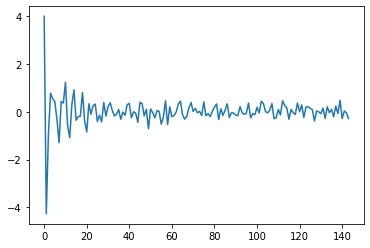

In [211]:
print(tar_train[0])
print(tar_train[296])
plt.plot(feat_train[0])
#plt.plot(feat_train[296])
#plt.plot(feat_train[449])

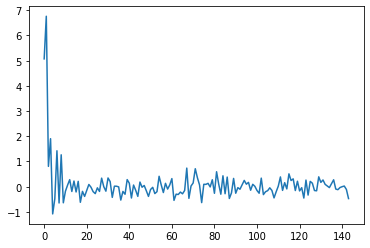

In [210]:
plt.plot(feat_train[449])

In [419]:
#learning the scaling transformation from the train data and applying it to both train and test set.

#creating scaling object
scaler = sklearn.preprocessing.StandardScaler()

#learning scaling from train set
scaler.fit(feat_train)

#applying scaling to both train and test set
feat_train = scaler.transform(feat_train)
feat_test = scaler.transform(feat_test)

In [420]:
#Creating an instance of a PCA object, which is an object capable of learning and applying PCA from/to data.
#We instruct the PCA to keep only N components
pca = sklearn.decomposition.PCA(n_components=256)

#This will learn PCA projection from train data
pca.fit(feat_train)

#Now we project the data
feat_train = pca.transform(feat_train)
feat_test = pca.transform(feat_test)

#this is only for scatter plot purposes
#projected_features = pca.transform(scaler.transform(features))

In [136]:
#Creating an instance of a Isomap object, which is an object capable of learning and applying Isomap from/to data.
#if we want to keep only a given number of components we can use the argument "n_components"
isomap = sklearn.manifold.Isomap(n_components=5)

#This will learn Isomap projection from data, mind that we are using the features only
isomap.fit(feat_train)

#Now we project the data into a from a high to a low dimensional space
feat_train = isomap.transform(feat_train)
feat_test = isomap.transform(feat_test)


[[-1033.0814128   -906.6366293   -970.25209631  -128.20852442
    921.90532815]
 [  138.98456351   249.49620597   -75.48755326  -335.32649945
    -64.64659095]
 [ -877.7403662   1481.52861035   953.13421285   467.70484157
    702.6317586 ]
 ...
 [ -906.62058754  -739.052022    -817.26432625   -20.49516801
    709.88511607]
 [ -825.47262836 -1262.0571684    641.69570318  -350.200899
   -661.57784279]
 [-1393.78441451   837.60150148  -239.10241246   137.58906609
     33.14860347]]
[[-2548.07906281  2291.46587671  -824.55016133 -1146.33059114
   -726.24565066]
 [ 2136.15158377   138.24169005  -319.75638085   588.32924606
   -300.42899188]
 [-1155.08055694 -1454.17398098  -155.38296242  -264.54292165
    284.03362639]
 ...
 [  377.60668275   142.54841305   977.16478905   756.56955659
     -9.74019329]
 [-1952.89976469  1537.68720007  -523.88806737  -446.89331572
   -353.42356885]
 [  138.83415114   248.90665133   -75.23745316  -333.41681643
    -64.18990944]]


In [213]:
print(feat_train.shape)
print(feat_test.shape)

(1136, 144)
(285, 144)


In [423]:
#Import the classifier
from sklearn.neural_network import MLPRegressor

##Creating an instance of a MLP regressor
#and setting it some option (max mum epoch, verbose on, activation of neurons)
#mlp = MLPRegressor(hidden_layer_sizes=(15,10,5), max_iter=500000, activation='relu', verbose=True, random_state = 20, learning_rate_init = 0.001, tol = 0.00001)
#mlp = MLPRegressor(hidden_layer_sizes=(8,3), max_iter=500000, activation='logistic', verbose=True, random_state = 20, learning_rate_init = 0.001, tol = 0.00001)
#*mlp = MLPRegressor(hidden_layer_sizes=(30,20,10), max_iter=500000, activation='relu', verbose=True, random_state = 20, learning_rate_init = 0.001, tol = 0.00001) # Overfitting
#mlp = MLPRegressor(hidden_layer_sizes=(30,20,10), max_iter=500000, activation='relu', verbose=True, random_state = 20, learning_rate_init = 0.001, tol = 0.00001)
#*mlp = MLPRegressor(hidden_layer_sizes=(500, 500, 300, 300, 200, 200, 100), max_iter=1000, activation='tanh', verbose=True, random_state = 20, learning_rate_init = 0.001, tol = 0.00001)
#mlp = MLPRegressor(hidden_layer_sizes=(500, 400, 300, 200, 100, 50, 30), max_iter=500000, activation='relu', verbose=True, random_state = 20, learning_rate_init = 0.001, tol = 0.00001)
#mlp = MLPRegressor(hidden_layer_sizes=(500, 500, 300, 300, 200, 200, 100), max_iter=500000, activation='relu', verbose=True, random_state = 20, learning_rate_init = 0.001, tol = 0.00001)

#mlp = MLPRegressor(hidden_layer_sizes=(500, 400, 300, 200, 100, 50, 30), max_iter=1000, activation='relu', verbose=True, random_state = 1, learning_rate_init = 0.01, tol = 0.00001)
#*mlp = MLPRegressor(hidden_layer_sizes=(300, 200, 100, 50, 30), max_iter=500000, activation='relu', verbose=True, random_state = 1, learning_rate_init = 0.0001, tol = 0.0000001, alpha = 0.0001)
#mlp = MLPRegressor(hidden_layer_sizes=(10, 5, 3), max_iter=500000, activation='logistic', verbose=True, random_state = 1, learning_rate_init = 0.001, tol = 0.0000001, alpha = 0.0001)
#mlp = MLPRegressor(hidden_layer_sizes=(500, 500, 300, 300, 200, 200, 100), max_iter=10000, activation='relu', verbose=True, random_state = 1, learning_rate_init = 0.0001, tol = 0.0000001, alpha = 0.1)
#mlp = MLPRegressor(hidden_layer_sizes=(128), max_iter=1000, activation='logistic', verbose=True, random_state = 1, learning_rate_init = 0.001, tol = 0.00001, alpha = 0.1)
mlp = MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=10000, activation='logistic', verbose=True, random_state = 1, learning_rate_init = 0.0001, tol = 0.00001, alpha = 0.1)

#train the model
mlp.fit(feat_train, tar_train)

#applying the the model on the test data (features)
tar_pred = mlp.predict(feat_test)

Iteration 1, loss = 0.26822659
Iteration 2, loss = 0.21862084
Iteration 3, loss = 0.19186073
Iteration 4, loss = 0.17818163
Iteration 5, loss = 0.17102865
Iteration 6, loss = 0.16681539
Iteration 7, loss = 0.16372454
Iteration 8, loss = 0.16093827
Iteration 9, loss = 0.15811776
Iteration 10, loss = 0.15515364
Iteration 11, loss = 0.15198165
Iteration 12, loss = 0.14859554
Iteration 13, loss = 0.14495337
Iteration 14, loss = 0.14110755
Iteration 15, loss = 0.13704473
Iteration 16, loss = 0.13283673
Iteration 17, loss = 0.12849497
Iteration 18, loss = 0.12411710
Iteration 19, loss = 0.11972150
Iteration 20, loss = 0.11539574
Iteration 21, loss = 0.11118903
Iteration 22, loss = 0.10714721
Iteration 23, loss = 0.10333799
Iteration 24, loss = 0.09975897
Iteration 25, loss = 0.09647355
Iteration 26, loss = 0.09351095
Iteration 27, loss = 0.09081937
Iteration 28, loss = 0.08846318
Iteration 29, loss = 0.08639765
Iteration 30, loss = 0.08463560
Iteration 31, loss = 0.08311660
Iteration 32, los

Iteration 253, loss = 0.07154966
Iteration 254, loss = 0.07156780
Iteration 255, loss = 0.07154905
Iteration 256, loss = 0.07155603
Iteration 257, loss = 0.07154189
Iteration 258, loss = 0.07153974
Iteration 259, loss = 0.07153730
Iteration 260, loss = 0.07154273
Iteration 261, loss = 0.07151806
Iteration 262, loss = 0.07153277
Iteration 263, loss = 0.07151657
Iteration 264, loss = 0.07151280
Iteration 265, loss = 0.07150467
Iteration 266, loss = 0.07150685
Iteration 267, loss = 0.07151023
Iteration 268, loss = 0.07150392
Iteration 269, loss = 0.07151553
Iteration 270, loss = 0.07149584
Iteration 271, loss = 0.07151304
Iteration 272, loss = 0.07150724
Training loss did not improve more than tol=0.000010 for 10 consecutive epochs. Stopping.


In [ ]:
print(mlp.)

In [ ]:
# #Creating an instance of a PCA object, which is an object capable of learning and applying PCA from/to data.
# #We instruct the PCA to keep only N components
# pca = sklearn.decomposition.PCA(n_components=3)

# #This will learn PCA projection from train data
# pca.fit(feat_train)

# #Now we project the data
# projected_features_train = pca.transform(feat_train)
# projected_features_test = pca.transform(feat_test)

# #this is only for scatter plot purposes
# projected_features = pca.transform(scaler.transform(features))

In [ ]:
# #Import the classifier
# from sklearn.neural_network import MLPRegressor

# ##Creating an instance of a MLP regressor
# #and setting it some option (max mum epoch, verbose on, activation of neurons)
# mlp = MLPRegressor(hidden_layer_sizes=(15,10,5), max_iter=500000, activation='tanh', verbose=True)

# #train the model
# mlp.fit(projected_features_train, tar_train)

# #applying the the model on the test data (features)
# tar_pred = mlp.predict(projected_features_test)

In [336]:
#tar_pred = sklearn.preprocessing.normalize(tar_pred, axis=1)
#np.linalg.norm(v)
print(tar_pred[0:10])

[[ 0.05473719 -0.10183794  0.2620956 ]
 [ 0.29959187 -0.3878198  -0.3804041 ]
 [ 0.1345996  -0.04502368  0.02609546]
 [ 0.66538196 -0.55063602 -0.3119022 ]
 [-0.21252076 -0.18063658 -0.11455853]
 [ 0.09289899 -0.16019834 -0.0838708 ]
 [-0.92922818 -0.254528    0.30603376]
 [-0.21137465 -0.19684579 -0.12327078]
 [ 0.08152314 -0.14022715  0.3302405 ]
 [ 0.07930064  0.09238751  0.07605666]]


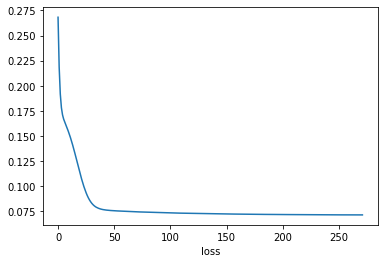

Mean squared error: 0.1250
Mean absolute error: 0.2619
Median absolute error: 0.2031
Coefficient of determination (R2 score): 0.5887
Explained variance score: 0.5888
R2 score on individual targets [0.64181335 0.64951974 0.47467918]
[0.15978346 0.1519811  0.06309928]
[0.29828921 0.28941409 0.19785974]
[0.22477356 0.21892385 0.16549261]


In [432]:
%matplotlib inline
#plotting the loss curve over training iteration 
plt.plot(mlp.loss_curve_)
plt.xlabel('iteration')
plt.xlabel('loss')
plt.show()

#computing a set of performance metrics

#mean squared error (lower the better)
print('Mean squared error: %.4f'% sklearn.metrics.mean_squared_error(tar_test, tar_pred))

#mean absolute error (lower the better)
print('Mean absolute error: %.4f'% sklearn.metrics.mean_absolute_error(tar_test, tar_pred))

#median absolute error (lower the better)
print('Median absolute error: %.4f'% sklearn.metrics.median_absolute_error(tar_test, tar_pred))

#coefficient of determination (r2 score): 1 is perfect prediction (it can get arbitrary negative)
print('Coefficient of determination (R2 score): %.4f'% sklearn.metrics.r2_score(tar_test, tar_pred))

#explained variance score: 1 is perfect prediction (it can get arbitrary worse)
print('Explained variance score: %.4f'% sklearn.metrics.explained_variance_score(tar_test, tar_pred))

#this is is a better represenation of the r2 score when working with multiple outputs
#as it provides a value for each target value
print('R2 score on individual targets',sklearn.metrics.r2_score(tar_test, tar_pred, multioutput='raw_values') )

print(sklearn.metrics.mean_squared_error(tar_test, tar_pred, multioutput='raw_values'))
print(sklearn.metrics.mean_absolute_error(tar_test, tar_pred, multioutput='raw_values'))
print(sklearn.metrics.median_absolute_error(tar_test, tar_pred, multioutput='raw_values'))


<IPython.core.display.Javascript object>


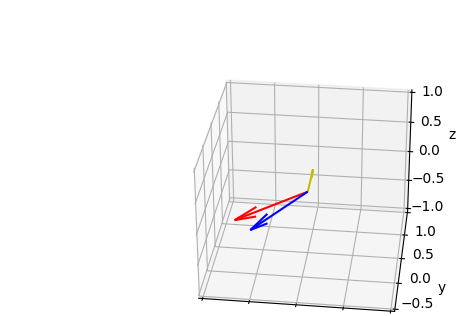

32.029350654515845


In [430]:
#https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

#https://stackoverflow.com/questions/27023068/plotting-3d-vectors-using-python-matplotlib
def PlotVectors(v_test, v_pred):
    %matplotlib nbagg
    #vectors=np.array( [ [0,0,1,1,-2,0], [0,0,2,1,1,0],[0,0,3,2,1,0],[0,0,4,0.5,0.7,0]]) 
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    #for vector in vectors:
    #Reference
    v = np.array([0,0.5,0])
    ax.quiver(0,0,0,v[0],v[1],v[2],
            pivot='tail',arrow_length_ratio=0.3, color = 'y')
    #Test
    v = np.array(v_test)
    vlength=np.linalg.norm(v)
    ax.quiver(0,0,0,v[0],v[1],v[2],
            pivot='tail',arrow_length_ratio=0.3/vlength, color = 'b')
    #Predict
    v = np.array(v_pred)
    vlength=np.linalg.norm(v)
    ax.quiver(0,0,0,v[0],v[1],v[2],
            pivot='tail',arrow_length_ratio=0.3/vlength, color = 'r')
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_zlim([-1,1])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()

d = 89
PlotVectors(tar_test[d], normalize(tar_pred[d]))
deg = []
for d in range(tar_test.shape[0]):
    deg = np.append(deg, np.rad2deg(angle_between(tar_test[d], tar_pred[d])))
    #print(deg[len(deg) - 1])
print(np.mean(deg))


In [ ]:
x = sklearn.metrics.mean_absolute_error(tar_test[:,1], tar_pred[:,1])
print(x) #14 #113

In [ ]:
x = sklearn.metrics.mean_absolute_error(tar_test, tar_pred, multioutput='raw_values')
print(x) #14 #113

In [400]:
print(sklearn.metrics.mean_squared_error(tar_pred, tar_train[0:tar_pred.shape[0],:], multioutput='raw_values'))
print(sklearn.metrics.mean_absolute_error(tar_pred, tar_train[0:tar_pred.shape[0],:], multioutput='raw_values'))
print(sklearn.metrics.r2_score(tar_pred, tar_train[0:tar_pred.shape[0],:], multioutput='raw_values'))

[0.73191611 0.74827416 0.16511883]
[0.69632923 0.71607342 0.33465013]
[-1.47175496 -1.51737359 -2.681401  ]


In [ ]:
print(tar_train[0:27,:].shape)
print(tar_pred.shape)

In [425]:
x = mlp.predict(feat_train)

print(sklearn.metrics.mean_squared_error(tar_train, x, multioutput='raw_values'))
print(sklearn.metrics.mean_absolute_error(tar_train, x, multioutput='raw_values'))
print(sklearn.metrics.r2_score(tar_train, x, multioutput='raw_values'))

[0.146265   0.14212282 0.05745536]
[0.28355096 0.28079465 0.18885962]
[0.66913646 0.67475629 0.52385904]


In [414]:
#merging everything into a single data structure
dataset = pd.DataFrame(features)
dataset['x'] = target[:,0]
dataset['y'] = target[:,1]
dataset['z'] = target[:,2]

#we can save the dataset to a file to resume working without re-computing the features (unless you want to change them)
dataset.to_csv('dataset.csv')

#displaying the data structure
#dataset

In [48]:
#no we reload from file and re-extract the three separate arrays containing features, labels, and filenames
imported_dataset = pd.read_csv('dataset.csv')

#we stored 7 features when the data structure was empty, so they eneded in culumns 0 to 6 (included)
#iloc[:,0:6] means : ==> all rows, 0:7 ==> columns 0 to 6 (7 is not included)
imported_features = dataset.iloc[:,0:768].to_numpy()#we stored 7 features when the data structure was empty, so they eneded in culumns 0 to 6 
imported_labels = np.zeros((imported_features.shape[0],3))
imported_labels[:,0] = dataset['x'] #we keep this as a pandas data structure, it will be handy to trace back misclassified files (because it's indexed)
imported_labels[:,1] = dataset['y']
imported_labels[:,2] = dataset['z']
print(imported_labels.shape)

KeyboardInterrupt: 